In [2]:
# mports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

# Import all the files
items = pd.read_csv("./data/items.csv")
categories = pd.read_csv("./data/categories.csv")
shops = pd.read_csv("./data/shops.csv")
training_data = pd.read_csv("./data/sales_train.csv")
columns = training_data.columns
sample_submission = pd.read_csv("./data/sample_submission.csv")
columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day'],
      dtype='object')

# EDA
Basic things about the data
 - `items` :
    - category_id is not unique
    - item_id is a unique number
    - item_name is the human text for above
 - `categories` :
    - category_id is a unique number
    - category_name is the human text for above
 - `shops` :
    - shop_id is a unique number
    - shop_name is the human text for above
 - `training_data` :
    - item_price isn't always the same for the same item_id! Sales do exist
    - date_block_num is the month the data is from (Jan 2013 is 0, Oct 2015 is 33)
    - item_cnt_day is products sold, this is our target. We are predicting a MONTHLY value though
- Submission: test.csv has ID which is (Shop ID, Item ID), submissions are a prediction for each of those

## Thoughts
- A Haggling score could be useful as I have noticed that identical items are sold for different prices
- Refunds do also exist (negative prices) which may also be important
- Might be worth breaking a month into weeks, making a prediction for each and then using the average

In [120]:
# Haggled Items are items that have been sold for different prices by the same store

# let's see if items are being sold cheaply
# I'm using one month of data just for my PC's sake
df = training_data[training_data["date_block_num"] == 0]
print(f"Shape of df: {df.shape}")

# 8115 Unique Items
print(f"Unique Item IDs: {df['item_id'].unique().shape[0]}")

average_prices = df.groupby(["item_id"])["item_price"].mean().reset_index()
average_prices.set_index("item_id", inplace=True)
print("\nAverage Prices:")
print(average_prices)
# Access average prices with average_prices.loc[id].values
print(f"Average price for item id 32: {average_prices.loc[32].values}")

Shape of df: (115690, 6)
Unique Item IDs: 8115

Average Prices:
          item_price
item_id             
19         28.000000
27       2325.000000
28        549.000000
29       2397.500000
32        338.110349
...              ...
22149     134.400000
22151     380.370052
22154     999.000000
22160     134.272727
22168     799.000000

[8115 rows x 1 columns]
Average price for item id 32: [338.11034921]


In [181]:
shops = df.groupby(["shop_id", "item_id"])["item_price"].mean()

# price is at: shops[shop_id][item_id]

# How much the price differs from the average, e.g. double price is 2x
price_multiplier = []
shop_list = []
item_list = []
shops.index
for shop, item in shops.index:
    # Makes sense to just do the maths and then some sort of mapping function based on that
    price_multiplier.append(shops[shop][item] / average_prices.loc[item].values)
    shop_list.append(shop)
    item_list.append(item)

print("Done.")


# "Above", "Average", "Below"
#price_status = []

Done.


In [204]:
price_info= pd.DataFrame(columns=["shop_id","item_id","price_multiplier"])
price_info["shop_id"] = shop_list
price_info["item_id"] = item_list
price_info["price_multiplier"] = price_multiplier
price_info["price_multiplier"] = price_info["price_multiplier"].astype(float)
price_info.head()

,shop_id,item_id,price_multiplier
0,0,32,0.653633
1,0,33,0.710313
2,0,35,0.632184
3,0,43,0.942431
4,0,51,0.557577


In [214]:
price_info.shape

(63224, 3)

In [217]:
#price_info.groupby(["shop_id"])["price_multiplier"].mean()
#df.sort_values(by=["shop_id", "item_id"])
average_sales = df.groupby(["shop_id", "item_id"])["item_cnt_day"].mean().reset_index()
average_sales["item_cnt_day"].values

sales_info = price_info
sales_info["average_sales"] = average_sales["item_cnt_day"].values

sales_info

,shop_id,item_id,price_multiplier,average_sales
0,0,32,0.653633,1.5
1,0,33,0.710313,1.0
2,0,35,0.632184,1.0
3,0,43,0.942431,1.0
4,0,51,0.557577,1.0
...,...,...,...,...
63219,59,22092,1.070043,2.0
63220,59,22130,1.034644,1.0
63221,59,22134,1.063752,2.0
63222,59,22151,1.048978,1.0


<function matplotlib.pyplot.show(close=None, block=None)>

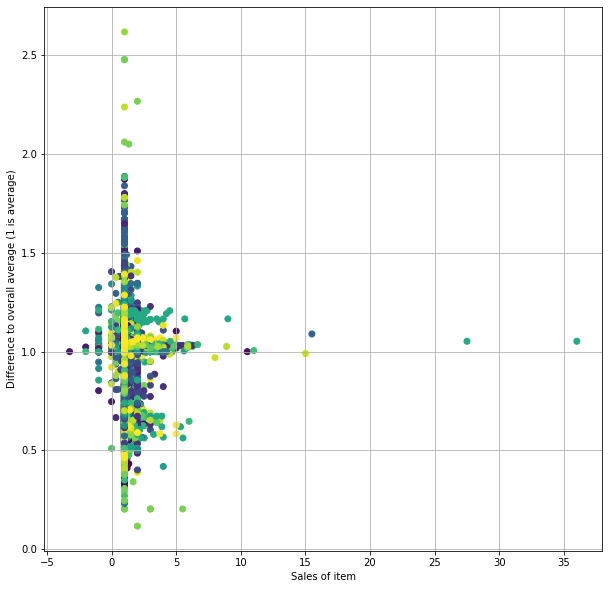

In [261]:
# To recap, we have compared the average price a shop sells at the the overall average
# Now we will see if there is a correlation between that and sales (I hope so)
plt.figure(figsize=(10,10))
#data = sales_info.drop(columns=["shop_id", "item_id"])
data=sales_info
#data.hist(bins=30)
plt.scatter(data["average_sales"], data["price_multiplier"], c=data["item_id"])
plt.grid()
plt.xlabel("Sales of item")
plt.ylabel("Difference to overall average (1 is average)")
plt.show

Total data points: 63224
We'll drop the highest 0.1% of values (63.224)
Sales above 5: 27
Sales above 4: 56
That'll do
Negative sales are refunds so will remove...
Actually will remove all 0 sales as well


<function matplotlib.pyplot.show(close=None, block=None)>

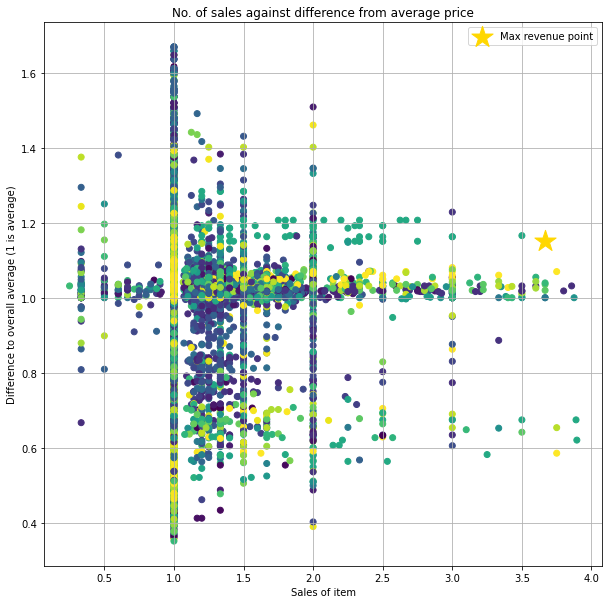

In [303]:
data=sales_info
plt.figure(figsize=(10,10))
# Maybe if I tidy up the data by removing outliers we can get more info
print(f"Total data points: {data.shape[0]}")
print(f"We'll drop the highest 0.1% of values ({data.shape[0]/1000})")

over_four = data["average_sales"][data["average_sales"] >4].count()
over_five = data["average_sales"][data["average_sales"] >5].count()
print(f"Sales above 5: {over_five}")
print(f"Sales above 4: {over_four}")
print(f"That'll do")
data = data[data["average_sales"] <4]

# Similar removal for price multiplier
data = data[data["price_multiplier"] <1.7]
data = data[data["price_multiplier"] >0.35]

print("Negative sales are refunds so will remove...")
print("Actually will remove all 0 sales as well")
data = data[data["average_sales"] > 0]


plt.scatter(data["average_sales"], data["price_multiplier"], c=data["item_id"])
plt.grid()
plt.xlabel("Sales of item")
plt.ylabel("Difference to overall average (1 is average)")


# "Max Revenue Point"
data["revenue"] = data["average_sales"] * data["price_multiplier"]
best_seller = data[data["revenue"] == data["revenue"].max()]
plt.scatter(best_seller["average_sales"], best_seller["price_multiplier"], marker="*", color="gold", s=500, label="Max revenue point")
plt.legend()
plt.title("No. of sales against difference from average price")
plt.show

# Conclusion: Sales aren't that great.

In [290]:
data["price_multiplier"].describe()
upper = data["price_multiplier"][data["price_multiplier"] >1.7].count()
print(upper)
lower = data["price_multiplier"][data["price_multiplier"] <0.35].count()
print(lower)

data = data[data["price_multiplier"] <1.7]
data = data[data["price_multiplier"] >0.35]

31
21
